In [1]:
# %matplotlib notebook

import os
import sys
import numpy as np
import pandas as pd
from scipy.signal import convolve2d

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import IPython.display as ipd

import scipy
from scipy.io import wavfile
import scipy.fftpack as fftpack

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.utils import *

from madmom.features.onsets import (spectral_flux, superflux)
from madmom.audio.spectrogram import (Spectrogram, SpectrogramProcessor,
                                      FilteredSpectrogramProcessor,
                                      LogarithmicFilteredSpectrogram,
                                      LogarithmicSpectrogramProcessor)

In [2]:
data = pd.read_csv('../data/data.csv', index_col=0)

In [3]:
# idx = 150
idx = 300
file = data.at[idx,'file']
signal = get_audio(file, normalize=True)
annotations = get_annotations(file)
sr = get_sample_rate(file)

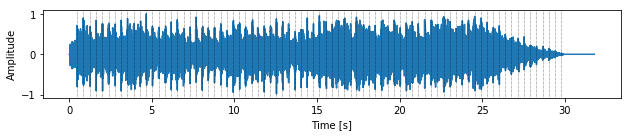

In [4]:
plot_audio(file)

In [5]:
play_audio(file)

## STFT

In [6]:
frame_size = 2048
hop_size = 512

In [7]:
# Functions

def signal_frame(signal, index, frame_size, hop_size, origin=0):
    frame_size = int(frame_size)
    num_samples = len(signal)
    ref_sample = int(index * hop_size)
    start = ref_sample - frame_size // 2 - int(origin)
    stop = start + frame_size

    if (stop < 0) or (start > num_samples):
        # window falls completely outside the actual signal, return just zeros
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        return frame
    elif (start < 0) and (stop > num_samples):
        # window surrounds the actual signal, position signal accordingly
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:num_samples - start] = signal
        return frame
    elif start < 0:
        # window crosses left edge of actual signal, pad zeros from left
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:] = signal[:stop, ]
        return frame
    elif stop > num_samples:
        # window crosses right edge of actual signal, pad zeros from right
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[:num_samples - start] = signal[start:, ]
        return frame
    # normal read operation
    return signal[start:stop, ]

In [8]:
frame_rate = sr/hop_size
window = np.hanning(frame_size) 
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_size, 1. / sr)[:num_fft_bins]

num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
frames = []    

# Slice audio into frames
for index in range(num_frames):
    frames.append(signal_frame(signal, index, frame_size, hop_size))

# Compute FFT    
fft = np.empty((num_frames, num_fft_bins), np.complex64)
for f, frame in enumerate(frames):
    fft_signal = np.multiply(frame, window)
    fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

spectrum = np.square(np.abs(fft))

spectrum = spectrum / np.max(spectrum)
thresh = -74.0 # dB
thresh = 10**(thresh/20.0)
spectrum = np.maximum(spectrum, thresh)

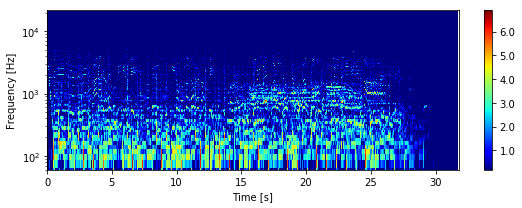

In [9]:
# Visualization

plt.figure(2, figsize=(8,3))
plt.imshow(np.log(1+ 1000*spectrum.T), extent=(0,len(signal)/sr, bin_frequencies[1], bin_frequencies[-1]),
           origin='lower', aspect='auto',cmap='jet');
plt.yscale('log')
plt.colorbar(format='%.1f');
plt.ylim([60, bin_frequencies[-1]])

plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]');
plt.tight_layout();

## Novelty curve (Grosche 2011)

In [10]:
bands = np.array([[0, 500], [500, 1250], [1250, 3125], 
                  [3125, 7812.5], [7812.5, np.floor(sr/2)]])
c = 1000

In [11]:
band_novelty_curves = np.zeros((bands.shape[0], spectrum.shape[0]))

# smoothed differentiator filter
diff_len = 0.3 # sec
diff_len = np.maximum(np.ceil(diff_len*sr/hop_size), 5)
diff_len = int(2*np.round(diff_len/2)+1) # make it odd
diff_filter = (np.hanning(diff_len)*
               np.concatenate((-1*np.ones(int(diff_len/2)), 
                               np.array([0]),
                               np.ones(int(diff_len/2)))))[np.newaxis]

# normalize band filter
norm_len = 5 # sec
norm_len = int(np.maximum(np.ceil(norm_len*sr/hop_size), 3))
norm_filter = np.hanning(norm_len)[np.newaxis]

for i, band in enumerate(bands):
    bins = np.around(band/(sr/frame_size))
    bins = np.maximum(1, bins)
    bins = np.minimum(np.around(frame_size/2)+1, bins)
    
    # smoothed differentiator
    band_data = spectrum[:,int(bins[0]):int(bins[1])].T
    band_data = np.log(1+band_data*c)/(np.log(1+c))
    padded_band_data = np.pad(band_data, 
                       ((0, 0), (int(diff_len/2), int(diff_len/2))), 
                       mode='edge')
    band_diff = convolve2d(padded_band_data, diff_filter, mode='same')
    band_diff = band_diff*(band_diff>0)
    shift = 5 # heuristic 
    band_diff = band_diff[:,int(diff_len/2)+shift:-int(diff_len/2)+shift]
    
    # normalize band
    norm_curve = convolve2d(np.sum(band_data, axis=0)[np.newaxis], 
                                   norm_filter/np.sum(norm_filter), mode='same')
    
    # boundary correction
    norm_filter_sum = ((np.sum(norm_filter)-np.cumsum(norm_filter))
                       /np.sum(norm_filter))[np.newaxis]
    norm_curve[:,:int(norm_len/2)] = (norm_curve[:,:int(norm_len/2)]/
                                     np.fliplr(norm_filter_sum[:,:int(norm_len/2)]))
    norm_curve[:,-int(norm_len/2):] = (norm_curve[:,-int(norm_len/2):]/ 
                                         norm_filter_sum[:,:int(norm_len/2)])
    
    band_diff = band_diff/norm_curve

    # compute novelty curve of band 
    novelty_curve = np.sum(band_diff, axis=0)
    band_novelty_curves[i,:] = novelty_curve
    
novelty_curve = np.mean(band_novelty_curves, axis=0)[np.newaxis]

# local average subtraction
smooth_len = 1.5 # sec
smooth_len = np.maximum(np.ceil(smooth_len*sr/hop_size), 3)
smooth_filter = np.hanning(smooth_len)[np.newaxis]
local_average = convolve2d(novelty_curve, smooth_filter/np.sum(smooth_filter), mode='same')

novelty_curve = novelty_curve-local_average
novelty_curve = ((novelty_curve>0)*novelty_curve)[0,:]

## Madmom onset detection function [2013]

In [12]:
sample_spec = Spectrogram('../data/audio/' + file + '.wav', circular_shift=True)
sample_log_filt_spec = LogarithmicFilteredSpectrogram(
    sample_spec, num_bands=24, mul=1, add=1)
odf = superflux(sample_log_filt_spec)

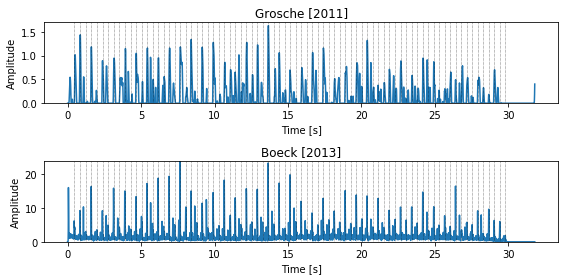

In [13]:
# Visualization 

time_vec = np.linspace(0, len(signal)/sr, len(novelty_curve))

fig, axes = plt.subplots(nrows=2, figsize=(8,4), num=3)
axes[0].plot(time_vec, novelty_curve)
axes[0].set_title('Grosche [2011]')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Amplitude')
# axes[0].set_xlim([5, 10])
axes[0].set_ylim([0, np.ceil(10*np.max(novelty_curve))/10])
for ann in annotations:
    axes[0].axvline(x=ann, color='k', linestyle=':', linewidth=0.5)

time_vec = np.linspace(0, len(signal)/sr, len(odf))

axes[1].plot(time_vec, odf)
axes[1].set_title('Boeck [2013]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Amplitude')
# axes[1].set_xlim([5, 10])
axes[1].set_ylim([0, np.ceil(10*np.max(odf))/10])
for ann in annotations:
    axes[1].axvline(x=ann, color='k', linestyle=':', linewidth=0.5)
    
fig.tight_layout()
plt.show;

## Tempogram

In [14]:
def calculate_tempogram(novelty, frame_rate):
    
    tempo_win_len = 6 # sec
    BPM = np.arange(30, 600)
    stepsize = int(np.ceil(frame_rate/5))
    
    win_len = int(np.around(tempo_win_len*frame_rate))
    win_len = win_len+np.mod(win_len, 2) - 1 # make it odd
    win = np.hanning(win_len)

    novelty = np.pad(novelty, (int(win_len/2), int(win_len/2)), 'constant')

    # Compute Fourier coefficients   
    f = BPM/60 # BPS
    t = np.arange(win_len)/frame_rate

    overlap = win_len-stepsize  
    win_num = int(np.fix((len(novelty)-overlap)/stepsize))
    
    tempogram = np.zeros((len(f), win_num), dtype=np.complex)

    # for each frequency given in f
    for i, f0 in enumerate(f):
        cosine = np.cos(f0*2*np.pi*t)
        sine = np.sin(f0*2*np.pi*t)

        for w in range(win_num):
            start = w*stepsize
            stop =  start+win_len   
            sig = novelty[start:stop]*win
            co = np.sum(sig*cosine)
            si = np.sum(sig*sine)
            tempogram[i,w] = (co+1j*si)

    tempogram = tempogram/np.sqrt(win_len)/np.sum(tempo_win_len)*win_len

    T = np.arange(win_len/2, len(novelty)-win_len/2+1, stepsize)/frame_rate
    T = T-T[0]
    
    return tempogram, T

In [15]:
frame_rate_boeck = 100
BPM = np.arange(30, 600)
tempo_win_len = 6
stepsize = int(np.ceil(frame_rate/5))

tempogram_grosche, T_grosche = calculate_tempogram(novelty_curve, frame_rate) 
tempogram_boeck, T_boeck = calculate_tempogram(odf, frame_rate_boeck) 

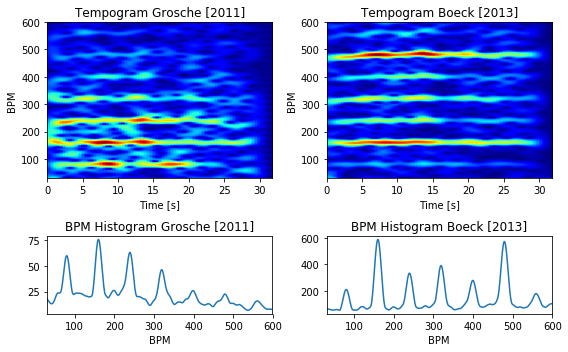

In [16]:
# Visualization

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5), 
                         gridspec_kw={'height_ratios': [2, 1]}, num=4)

axes[0,0].set_title('Tempogram Grosche [2011]')
axes[0,0].imshow(abs(tempogram_grosche), origin='lower', aspect='auto', cmap='jet',
           extent=(0, len(signal)/sr, BPM[0], BPM[-1]))
axes[0,0].set_xlabel('Time [s]')
axes[0,0].set_ylabel('BPM')

BPM_mean = np.mean(abs(tempogram_grosche), axis=1)
axes[1,0].set_title('BPM Histogram Grosche [2011]')
axes[1,0].plot(BPM, BPM_mean)
axes[1,0].set_xlabel('BPM')
axes[1,0].set_xlim((BPM[0], BPM[-1]))
axes[1,0].set_ylabel('')

axes[0,1].set_title('Tempogram Boeck [2013]')
axes[0,1].imshow(abs(tempogram_boeck), origin='lower', aspect='auto', cmap='jet',
           extent=(0, len(signal)/sr, BPM[0], BPM[-1]))
axes[0,1].set_xlabel('Time [s]')
axes[0,1].set_ylabel('BPM')

BPM_mean = np.mean(abs(tempogram_boeck), axis=1)
axes[1,1].set_title('BPM Histogram Boeck [2013]')
axes[1,1].plot(BPM, BPM_mean)
axes[1,1].set_xlabel('BPM')
axes[1,1].set_xlim((BPM[0], BPM[-1]))
axes[1,1].set_ylabel('')

fig.tight_layout()
plt.show()


## PLP Curve

In [17]:
tempogram = tempogram_grosche
tempogram_abs = np.abs(tempogram)
T = T_grosche

In [18]:
num_tempogram_frames = tempogram_abs.shape[1]

# cumulate periodiciy kernels
win_len = np.around(tempo_win_len*frame_rate)
win_len = win_len + np.mod(win_len, 2)-1 # make it odd
window = np.hanning(win_len)
window = window/(np.sum(window)/win_len) 
window = window/(win_len/stepsize) 

t = T*frame_rate
PLP = np.zeros(num_tempogram_frames*stepsize)  

# overlap add
for frame in range(num_tempogram_frames):
    t0 = int(np.ceil(t[frame]-win_len/2))
    t1 = int(np.ceil(t[frame]+win_len/2))
    
    local_max_idx = np.argmax(tempogram_abs[:, frame])
    
    phase = np.angle(tempogram[local_max_idx, frame])
    T_period = frame_rate*60/BPM[local_max_idx] # period length   
    cosine = window*np.cos(np.arange(win_len)*(1/T_period)*2*np.pi-phase) 
    
    if t0 < 1:
        cosine = cosine[-t0+1:]
        t0 = 1
    if t1 > len(PLP):
        cosine = cosine[0:(len(cosine)+len(PLP)-t1)]
        t1 = len(PLP)
 
    PLP[t0:t1] = PLP[t0:t1] + cosine

# half wave rectification
PLP = PLP*(PLP>0)

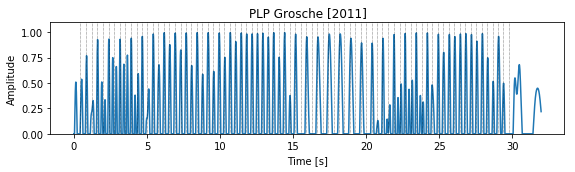

In [19]:
# Visualisization

plt.figure(num=5, figsize=(8,2.5))
time_vec = np.linspace(0, len(PLP)/frame_rate, len(PLP))
plt.plot(time_vec, PLP)
plt.title('PLP Grosche [2011]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
# plt.xlim([0,15])
plt.ylim([0, np.max(PLP)+0.1])
for ann in annotations:
    plt.axvline(x=ann, color='k', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show;